In [8]:
!gsutil -m cp gs://anon_bucket/model/cats_vs_dogs.h5 .

Copying gs://anon_bucket/model/cats_vs_dogs.h5...
/ [1/1 files][  8.9 MiB/  8.9 MiB] 100% Done                                    
Operation completed over 1 objects/8.9 MiB.                                      


In [9]:
import tensorflow as tf
model = tf.keras.models.load_model('cats_vs_dogs.h5')
model.summary()

2023-06-24 07:08:42.738413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 07:08:49.390246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-24 07:08:49.391491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'f11276427',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/opt/conda/lib/python3.10/site-packages/IPython',
 'ipython_version': '8.14.0',
 'os_name': 'posix',
 'platform': 'Linux-5.10.0-23-cloud-amd64-x86_64-with-glibc2.31',
 'sys_executable': '/opt/conda/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.10.11 | packaged by conda-forge | (main, May 10 2023, '
                '18:58:44) [GCC 11.3.0]'}


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [26]:
classes = ['Cat', 'Dog']
def display_pred(image_path):
    plt.imshow(plt.imread(image_path))
    x = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    x = tf.keras.preprocessing.image.img_to_array(x)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    pred = model.predict(x)[0]
    
    plt.title('Pred: {}'.format(classes[int(pred > 0.5)]))
    plt.show()
    print(pred)
    

1/1 [==============================] - 0s 34ms/step


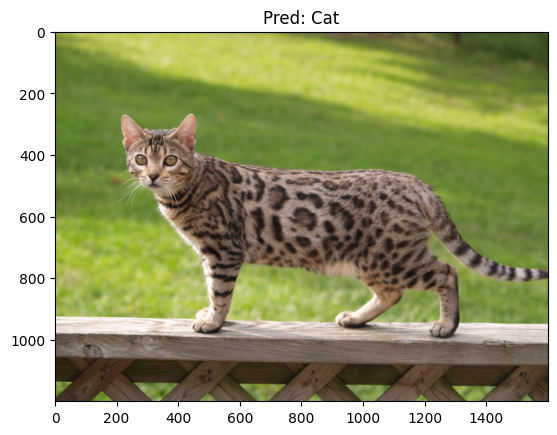

[0.00042999]


In [29]:
images = ['images/cat1.jpg', 'images/cat2.jpg', 'images/dog1.jpg', 'images/dog2.jpg', ]
display_pred(images[1])

1/1 [==============================] - 0s 35ms/step


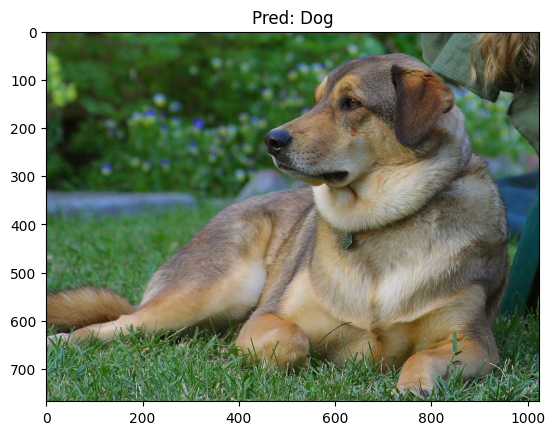

[0.9928476]


In [28]:
display_pred(images[-1])

In [31]:
%%writefile prediction.py

import tensorflow as tf
import numpy
import os
import base64

MODEL_NAME = 'cats_vs_dogs.h5'
CLASS_NAMES = ['Cat', 'Dog']

class CatsVsDogsPrediction:
    def __init__(self, model):
        self._model = model
    def _preprocess(self, instances, size=128):
        num_examples = len(instances)
        x_batche = np.zeroS((num_examples, size, size, 3))
        for i in range(num_examples):
          x = np.array(bytearray(base64.b64decode(instances[i])))
          x = np.reshape(x, (size, size, 3))  # decoding
          x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
          x_batch[i] = x
        return x_batch

    def _post_process(self, preds):
      resulst = []
      for i, pred in enumerate(preds):
        p = np.squeeze(pred)
        results.append({
          'index':i,
          'class_name': CLASS_NAME[int(p > 0.5)],
          'raw_value': '{:.4f}'.format(p)
          })
      return results
    
    def predict(self, instances, **kwargs):
        if 'size' in kwargs:
          size = int(kwargs.get('size'))
        else:
          size = 128  # default size
        # preprocess
        x_batch = self.preprocess(instances, size)
        # predict
        preds = self._model.predict(x_batch)

        results = self._postprocess(preds)
        return results
        
        # post preprocess
        return results
    
    @classmethod
    def from_path(cls, model_dir):
        model = tf.keras.models.load_model(os.path.join(model_dir, MODEL_NAME))
        return cls(model)

Overwriting prediction.py


In [41]:
%%writefile setup.py
# setup scriptq
from setuptools import setup
setup (
  name ='cats_vs_dogs',
  version='0.0.1',
  include_package_data=False,
  scripts=['prediction.py']
)

Overwriting setup.py


In [ ]:
!python3 setup.py sdist --formats=gztar

* created: dist/cats_vs_dogs-0.0.1.tar.gz
* create folder dist to bucket


In [44]:
!gsutil cp dist/cats_vs_dogs-0.0.1.tar.gz gs://anon_bucket/dist/

Copying file://dist/cats_vs_dogs-0.0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      


### models
* ai-platform/models/create a model (name:cats_vs_dogs) : create
* model: naem:cats_vs_dogs
    * version: v1
    python_version:3.7
    framework:custom prediction routine
    ml routine version:1.15
    model_urI:<browse> anon_bucket/model <select>
    package-path:dists/*tar.gz
    prediction class: `prediction.CatsVsDogsPrediction` <prediction.py class name>
    
* save the model

### predictions


In [ ]:
from googleapiclient import discovery
from PIL import image
import os
import base_64

service = discovery.build('ml','v1', cache_discovery=False)


def get_pred_from_model(body, project_name, model_name):
  return service.projects().predict(
    name='projects/{}/models/{}'.format(project_name, model_name),
    body = body
  ).execute()


project_name = 'son-of-anton-368302'
model_name = 'cats_vs_dogs'


images
instances = []
size =128

for image in images:
img = Image.open(image)
img = img.resize((size, size), Image.ANTIALIAS)

instances.append(
  base64.b64encoder(img.tobytes()).decode()
  )
img.close()


body = [
  'instances': instances,
  'size': size
]

### De-allocate resources to avoid billing
* response = get_pred_from_model(body, project_name, model_name)
* notebooks <select_notebook> -> stop
* version -> dropdown -> delete
* model -> dropdown -> delete
* remove all resources from bucket